<a href="https://colab.research.google.com/github/sayan0506/Capsule-Network-Implementation/blob/main/Capsule_Network_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementing Capsule Network using Tensorflow**

Installing Dependencies

In [2]:
# install keras livelossplot
!pip -q install livelossplot

# install wandb
!pip install --upgrade wandb

     |████████████████████████████████| 2.1MB 20.2MB/s 
     |████████████████████████████████| 133kB 57.2MB/s 
     |████████████████████████████████| 163kB 54.7MB/s 
     |████████████████████████████████| 102kB 13.4MB/s 
     |████████████████████████████████| 71kB 9.7MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=1522a0d1bfba06caf108cf0499e1ce58e1848c6e12e395f4e66c41324700f603
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=46feb36aeeebafd1801399144f5ab20e34d4d344be3b9ca5b33f7952536ffaf6
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


## Import Dependencies

In [88]:
import random
from datetime import datetime
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.datasets import mnist
import seaborn as sns
from tqdm import tqdm

from keras.utils.vis_utils import plot_model

## Environment Setup

**Improve Reproducibility**

In [4]:
# improve reproducibility and make the implementation more deterministic
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity")% 2**32 - 1)

**GPU allocation checkup**

In [5]:
# testing whether the GPU is allocated or not
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**Setup wandb(Weights  and Biases) environment**

In [6]:
import wandb
from wandb.keras import WandbCallback

# authorize
# wandb.login()

## **Load Standard MNIST Dataset using Keras**

[MNIST Reference](https://keras.io/api/datasets/mnist/#load_data-function)

In [7]:
# load mnist by using standard train_test_split
(x_train, y_train), (x_test, y_test) = mnist.load_data(path = "mnist.npz")

11493376/11490434 [==============================] - 0s 0us/step


## **Data Inspection on MNIST**

In [8]:
print(f'Train input shape {x_train.shape}')
print(f'Train input shape {y_train.shape}')
print(f'Test input shape {x_test.shape}')
print(f'Test label shape {y_test.shape}')

Train input shape (60000, 28, 28)
Train input shape (60000,)
Test input shape (10000, 28, 28)
Test label shape (10000,)


#### **Analyzing train and test distribution**

In [9]:
# dataframe for train distribution
train_df = pd.DataFrame(y_train, columns = ['Targets'])

# dataframe for test distribution
test_df = pd.DataFrame(y_test, columns = ['Targets'])

# train and test value counts
train_c = train_df.value_counts()
test_c = test_df.value_counts()

In [10]:
# class ids
class_ids = [i for i in range(10)]
print(f'Class ids {class_ids}')

Class ids [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


#### **Visualize the distribution for train and test set**


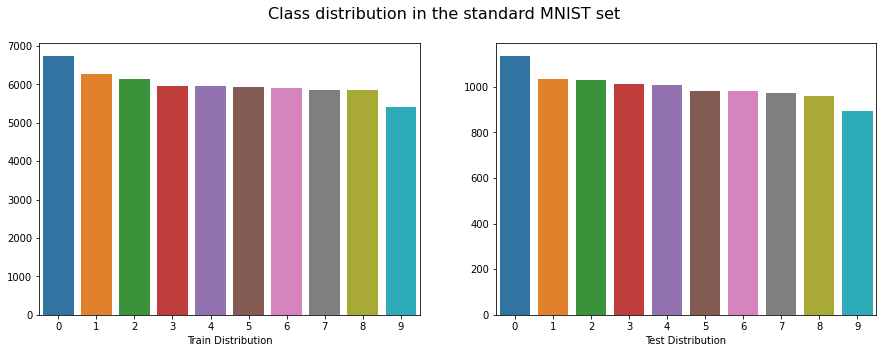

In [11]:
fig = plt.figure(figsize = (15,5))
fig.suptitle('Class distribution in the standard MNIST set', fontsize = 16)
fig.tight_layout()

# train distribution
fig.add_subplot(121)
sns.barplot(x = class_ids, y = train_c.values)
plt.xlabel('Train Distribution')

# test distribution
fig.add_subplot(122)
sns.barplot(x = class_ids, y = test_c.values)
plt.xlabel('Test Distribution')

plt.show()

We can see both train and test data are stratified split

#### **Sample Visualization of MNIST samples for individual Classes**

Picking random sample of each class from train set and visualize  

In [12]:

def mnist_vis(x_train, y_train, class_ids):
  '''
  Visualize random MNIST samples
  '''
  index_list = [random.choice([j for j,label in enumerate(y_train) if label==i])
   for i in class_ids]
  
  # obtaining sample images from train set
  sample_img = [x_train[index] for index in index_list]
  
  rows = 2
  cols = int(len(index_list)/rows)

  fig = plt.figure(figsize = (15,5))
  fig.suptitle('MNISt samples visualization', fontsize = 16)
  #fig.tight_layout()
  
  for a,idx in enumerate(index_list):
    fig.add_subplot(rows, cols, a+1)
    plt.imshow(x_train[idx], cmap = 'gray')
    plt.xlabel(f'Label: {a}')
    plt.xticks([])
    plt.yticks([])

  plt.show()

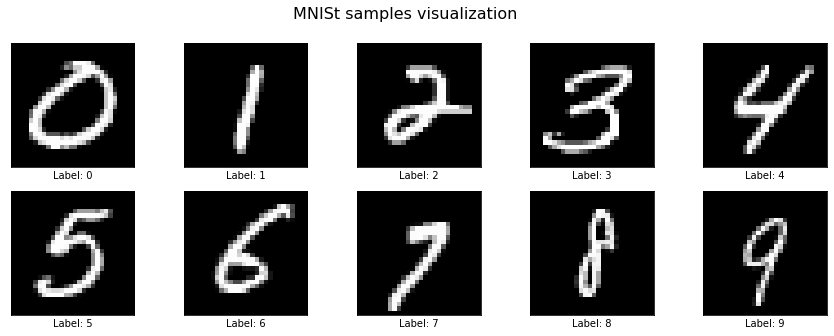

In [13]:
# calling visualization
mnist_vis(x_train, y_train, class_ids)

## **Data Preperation MNIST**
Data preprocessing steps include

1. Converting image pixels to float32
2. Normalizing the pixels
3. Reshaping

In [14]:
def mnist_prep(x_train, x_test):
  # convert images pixel to standard float32
  x_train_norm = tf.cast(x_train, dtype = tf.float32)
  x_test_norm = tf.cast(x_test, dtype = tf.float32)
  
  # normalize pixels
  x_train_norm = x_train_norm/255.0
  x_test_norm = x_test_norm/255.0

  # reshape the data (m, nh, nw, nc) nc = 1
  x_train = tf.expand_dims(x_train_norm, axis = -1)
  x_test = tf.expand_dims(x_test_norm, axis = -1)

  return x_train, x_test

In [15]:
# loading pre-processes data
x_train_pro, x_test_pro = mnist_prep(x_train, x_test)

print(f'Preprocessed train input shape {x_train_pro.shape}')
print(f'Preprocessed test input shape {x_test_pro.shape}')

Preprocessed train input shape (60000, 28, 28, 1)
Preprocessed test input shape (10000, 28, 28, 1)


#### **Evaluating the pre-processing steps**

In [16]:
print(f'Train test input shapes: {x_train_pro.shape, x_test_pro.shape}')
print(f'Train test output shapes: {y_train.shape, y_test.shape}')

# both the input image format are same or not
assert x_train_pro.shape[1:] == x_test_pro.shape[1:]
# checking lenghth of input and label
assert x_train_pro.shape[0] == y_train.shape[0] and x_test_pro.shape[0] == y_test.shape[0]
# checking image data type
assert x_train_pro.dtype == x_test_pro.dtype

print("All assertion test cases passed")

Train test input shapes: (TensorShape([60000, 28, 28, 1]), TensorShape([10000, 28, 28, 1]))
Train test output shapes: ((60000,), (10000,))
All assertion test cases passed


#### **Data Formatting**

In [17]:
training_dataset_size = x_train_pro.shape[0]
testing_dataset_size = x_test_pro.shape[0]

**Data formatting**

Defining Hyprparameters

In [18]:
# Batch size of data
batch_size = 64

Formatting Train dataset

In [19]:
# converting the tensor of train and test data to tf dataset format
# we pass train data tensors as tuples
dataset = tf.data.Dataset.from_tensor_slices((x_train_pro, y_train))
# shuffling the samples
# setting reshuffling flag to True so that after every iteration the sample of train data will be reshuffled,
# which will give more uniformity to training performance
dataset = dataset.shuffle(buffer_size = len(dataset), reshuffle_each_iteration = True)
dataset = dataset.batch(batch_size = batch_size)

Formatting test dataset

In [20]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_pro, y_test))
test_dataset = test_dataset.batch(batch_size = batch_size)

## Model Hyperparameters

In [25]:
# defining the dictionary for the model hyperparameters
params = {
    "no_of_conv_kernels": 256,
    "no_of_primary_capsules": 32, 
    "no_of_secondary_capsules": 10,
    "primary_capsules_vector": 8,
    "secondary_capsule_vector": 16,
    "r": 3
}

In [22]:
# parameters based on the paper
# numerical stabilizer for the squashing function
epsilon = 1e-7
# for positive margin
m_plus = 0.9
# for negative margin
m_minus = 0.1

# regularization coefficient
lambda_ = 0.5
# learning rate
alpha = 0.0005
epochs = 50
no_of_secondary_capsules = 10

# optimizer is Adam
optimizer = tf.keras.optimizers.Adam()

## **Model Building**

Building the Capsule Network Model from scratch using Keras functional API and sub-class architecture

In [75]:
# passing the abstract class for Model api
class CapsuleNetwork(tf.keras.Model):
  def __init__(self, no_of_conv_kernels, no_of_primary_capsules, primary_capsules_vector, 
               no_of_secondary_capsules, secondary_capsule_vector, r):
    # passing the class name to super class so that we can use functionality of abstract class
    super(CapsuleNetwork, self).__init__()
    self.no_of_conv_kernels = no_of_conv_kernels
    self.no_of_primary_capsules = no_of_primary_capsules
    self.primary_capsules_vector = primary_capsules_vector
    self.no_of_secondary_capsules = no_of_secondary_capsules
    self.secondary_capsule_vector = secondary_capsule_vector
    self.r = r

    # with operation block helps to implement exception handling in short way
    # tf.name_scope() helps to create a context manager while defining a python operation here
    with tf.name_scope("Variables") as scope:
      self.convolution = tf.keras.layers.Conv2D(self.no_of_conv_kernels, [9,9], strides=[1,1], name = 'ConvolutionLayer',
                                                activation = 'relu')
      # we need total 32 blocks each of having 8 convolution kernel channels
      # for the each convolution block total 36 vectors are there, each of having 8 dimensions
      self.primary_capsule = tf.keras.layers.Conv2D(self.no_of_primary_capsules * self.primary_capsules_vector, 
                                                    [9,9], strides = [2,2], name = 'PrimaryCapsule')
      # defining the parameters for capsule activation of secondary capsule layer
      # for MNIST we can also call it as digit capsule layer
      self.w = tf.Variable(tf.random_normal_initializer()(shape = [1,1152, self.no_of_secondary_capsules, self.secondary_capsule_vector, 
                                                                   self.primary_capsules_vector]), dtype = tf.float32,
                           name = 'PoseEstimation', trainable = True)
      
      # defining the reconstruction part/decoder section
      self.dense_1 = tf.keras.layers.Dense(units = 512, activation = 'relu')
      self.dense_2 = tf.keras.layers.Dense(units = 1024, activation = 'relu')
      self.dense_3 = tf.keras.layers.Dense(units = 784, activation = 'sigmoid', dtype = tf.float32)

  # overwriting the function of abstract class
  def build(self, input_shape):
    pass

  # defining the squash function which helps to create capsules
  # capsules are of single length(which is the prediction value)
  def squash(self, s):
    # creating a context manager for squashing operation
    with tf.name_scope('SquashFunction') as scope:
      # using L1 norm across the channels or the capsules
      s_norm = tf.norm(s, axis=-1, keepdims = True)
      return tf.square(s_norm/(1+tf.square(s_norm)) * s/(s_norm))
    
  # decorating as tensorflow function which will be callable using the instance
  @tf.function 
  def call(self, inputs):
    input_x, y = inputs
    # input_x.shape: (None, 28,28,1)
    # y.shape: (None, 10)

    # passing through concolution layer
    x = self.convolution(input_x) # x.shape: (None, 20,20, 256)
    x = self.primary_capsule(x) # x.shape: (None, 6, 6, 256)

    with tf.name_scope("CapsuleFormation") as scope:
      u = tf.reshape(x, (-1, self.no_of_primary_capsules * x.shape[1] * x.shape[2], 8)) # u.shape: (None, 1152, 8)
      # adding exta dimension at -2th index i.e. after 1152, i.e there are 1152 primary capsules each of dimension 8
      u = tf.expand_dims(u, axis = -2) # u.shape: (None, 1152, 1, 8)
      u = tf.expand_dims(u ,axis = -1) # u.shape: (None, 1152, 1, 8, 1)
      # calculation for activation input at secondary capsule layer  
      u_hat = tf.matmul(self.w, u) # u_hat.shape: (None, 1152, 10, 16, 1)
      # at squeeze function squeezes the dimension to 4
      u_hat = tf.squeeze(u_hat, [4]) # u_hat.shape: (None, 1152, 10, 16)
      
    with tf.name_scope("DynamicRouting") as scope:
      b = tf.zeros((input_x.shape[0], 1152, self.no_of_secondary_capsules, 1)) # b.shape: (None, 1152, 10, 1)
      # total r iterations will be there for dynamic routing to optimize routing coefficient
      for i in range(self.r):
        # self.r = 3
        # routing coefficient
        c = tf.nn.softmax(b, axis = -2) # c.shape: (None, 1152, 10, 1)
        # in secondary capsule layer total 10 capsules each of length 1 and dimension = 16 
        s = tf.reduce_sum(tf.multiply(c, u_hat), axis = 1, keepdims = True) # s.shape: (None, 1, 10, 16)
        # squashing the vectors so that it can provide prediction as length and 16 D regarding the pose estimation
        v = self.squash(s) # v.shape: (None, 1, 10, 16)
        agreement = tf.squeeze(tf.matmul(tf.expand_dims(u_hat, axis = -1), tf.expand_dims(v, axis = -1), transpose_a = True), [4])
        # agreement.shape: (None, 1152, 10, 1)
        # agreement parameters defines whether the 1152 primary capsules whether have strongly agreement relationship with
        # secondary capsule layer or not
        # before matmul following intermediate shapes are present, they are assigned for understanding and better reprsentation
        # u_hat.shape(intermediate): (None, 1152, 10, 16, 1)
        # v.shape(intermediate): (None, 1, 10, 16, 1)
        # since the 1st parameter of matmul is to be transposed its shape becomes: (None, 1152, 10, 1, 16)
        # now matmul is performed in the last two  dimensions, and others are broadcasted
        # before squeezing we have an intermediate shape (None, 11852, 10, 1, 1)
        b+= agreement

    with tf.name_scope('Masking') as scope:
      y = tf.expand_dims(y, axis = -1) # y.shape: (None, 10, 1)
      y = tf.expand_dims(y, axis = 1) # y.shape(None, 1, 10, 1)  
      mask = tf.cast(y, dtype = tf.float32) # mask.shape: (None, 1, 10, 1)
      v_masked = tf.multiply(mask, v) # v_masked.shape: (None, 1, 10, 16)

    with tf.name_scope('Reconstruction') as scope:
      v_ = tf.reshape(v_masked, [-1, self.no_of_secondary_capsules * self.secondary_capsule_vector]) #v_.shape: (None, 160)
      reconstructed_image = self.dense_1(v_) # reconstructed_image.shape: (none, 512)
      reconstructed_image = self.dense_2(reconstructed_image) # reconstructed_image.shape: (None, 1024)
      reconstructed_image = self.dense_3(reconstructed_image) # reconstructed_image.shape: (None, 784)

    return v, reconstructed_image

  @tf.function
  def predict_capsule_output(self, inputs):
    input_x, y = inputs
    # input_x.shape: (None, 28,28,1)
    # y.shape: (None, 10)

    # passing through concolution layer
    x = self.convolution(input_x) # x.shape: (None, 20,20, 256)
    x = self.primary_capsule(x) # x.shape: (None, 6, 6, 256)

    with tf.name_scope("CapsuleFormation") as scope:
      u = tf.reshape(x, (-1, self.no_of_primary_capsules * x.shape[1] * x.shape[2], 8)) # u.shape: (None, 1152, 8)
      # adding exta dimension at -2th index i.e. after 1152, i.e there are 1152 primary capsules each of dimension 8
      u = tf.expand_dims(u, axis = -2) # u.shape: (None, 1152, 1, 8)
      u = tf.expand_dims(u ,axis = -1) # u.shape: (None, 1152, 1, 8, 1)
      # calculation for activation input at secondary capsule layer  
      u_hat = tf.matmul(self.w, u) # u_hat.shape: (None, 1152, 10, 16, 1)
      # at squeeze function squeezes the dimension to 4
      u_hat = tf.squeeze(u_hat, [4]) # u_hat.shape: (None, 1152, 10, 16)

    with tf.name_scope("DynamicRouting") as scope:
      b = tf.zeros((input_x.shape[0], 1152, self.no_of_secondary_capsules, 1)) # b.shape: (None, 1152, 10, 1)
      # total r iterations will be there for dynamic routing to optimize routing coefficient
      for i in range(self.r):
        # self.r = 3
        # routing coefficient
        c = tf.nn.softmax(b, axis = -2) # c.shape: (None, 1152, 10, 1)
        # in secondary capsule layer total 10 capsules each of length 1 and dimension = 16 
        s = tf.reduce_sum(tf.multiply(c, u_hat), axis = 1, keepdims = True) # s.shape: (None, 1, 10, 16)
        # squashing the vectors so that it can provide prediction as length and 16 D regarding the pose estimation
        v = self.squash(s) # v.shape: (None, 1, 10, 16)
        agreement = tf.squeeze(tf.matmul(tf.expand_dims(u_hat, axis = -1), tf.expand_dims(v, axis = -1), transpose_a = True), [4])
        # agreement.shape: (None, 1152, 10, 1)
        # agreement parameters defines whether the 1152 primary capsules whether have strongly agreement relationship with
        # secondary capsule layer or not
        # before matmul following intermediate shapes are present, they are assigned for understanding and better reprsentation
        # u_hat.shape(intermediate): (None, 1152, 10, 16, 1)
        # v.shape(intermediate): (None, 1, 10, 16, 1)
        # since the 1st parameter of matmul is to be transposed its shape becomes: (None, 1152, 10, 1, 16)
        # now matmul is performed in the last two  dimensions, and others are broadcasted
        # before squeezing we have an intermediate shape (None, 11852, 10, 1, 1)
        b+= agreement

    return v

  @tf.function
  def regenerate_image(self, inputs):
    with tf.name_scope('Reconstruction') as scope:
      v_ = tf.reshape(v_masked, [-1, self.no_of_secondary_capsules * self.secondary_capsule_vector]) #v_.shape: (None, 160)
      reconstructed_image = self.dense_1(v_) # reconstructed_image.shape: (none, 512)
      reconstructed_image = self.dense_2(reconstructed_image) # reconstructed_image.shape: (None, 1024)
      reconstructed_image = self.dense_3(reconstructed_image) # reconstructed_image.shape: (None, 784)

    return reconstructed_image

In [76]:
# defining the CapsuleNetwork model
# **params helps to pass constructor attributes as a dictionary
model = CapsuleNetwork(**params)

## **Model Training**

**Defining safe_norm which helps to make the squashing node a deterministic one**

In [77]:
def safe_norm(v, axis = -1, epsilon = 1e-07):
  v_ = tf.reduce_sum(tf.square(v), axis = axis, keepdims = True)
  return tf.sqrt(v_ + epsilon)

**Defining the loss function**

In [78]:
def loss_function(v, reconstructed_image, y, y_image):
  prediction = safe_norm(v)
  prediction = tf.reshape(prediction, [-1, no_of_secondary_capsules])

  left_margin = tf.square(tf.maximum(0.0, m_plus - prediction))
  right_margin = tf.square(tf.maximum(0.0, prediction - m_minus))

  l = tf.add(y * left_margin, lambda_ * (1.0 - y) * right_margin)

  margin_loss = tf.reduce_mean(tf.reduce_sum(l, axis = -1))

  y_image_flat = tf.reshape(y_image, [-1, 784])
  reconstruction_loss = tf.reduce_mean(tf.square(y_image_flat - reconstructed_image))

  loss = tf.add(margin_loss, alpha * reconstruction_loss)

  return loss

**Defining training step**

In [79]:
def train(x, y):
  y_one_hot = tf.one_hot(y, depth = 10)
  with tf.GradientTape() as tape:
    v, reconstructed_image = model([x, y_one_hot])
    loss = loss_function(v, reconstructed_image, y_one_hot, x)
  grad = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grad, model.trainable_variables))

  return loss

**Summary trace-off after model initiaization**

In [83]:
_ = train(x_train_pro[:32], y_train[:32])

Model: "capsule_network_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ConvolutionLayer (Conv2D)    multiple                  20992     
_________________________________________________________________
PrimaryCapsule (Conv2D)      multiple                  5308672   
_________________________________________________________________
dense_24 (Dense)             multiple                  82432     
_________________________________________________________________
dense_25 (Dense)             multiple                  525312    
_________________________________________________________________
dense_26 (Dense)             multiple                  803600    
Total params: 8,215,568
Trainable params: 8,215,568
Non-trainable params: 0
_________________________________________________________________


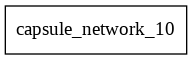

In [85]:
# model summary
model.summary()
# plot_model
plot_model(model)

#### **Defining training checkpoints**

In [107]:
checkpoint_path = './logs/model/capsule'

# defining parameters to record dynamic timestamp
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")

logdir = './logs/func/%s' % stamp
writer = tf.summary.create_file_writer(logdir)

scalar_logdir = './logs/scalar/%s' % stamp
file_writer = tf.summary.create_file_writer(scalar_logdir + "/metrics")

#### **Defining prediction function**

In [108]:
def predict(model, x):
  pred = safe_norm(model.predict_capsule_output(x))
  pred = tf.squeeze(pred, [1])
  return np.argmax(pred, axis = 1)[:,0]

**Model summary traceoff**

In [109]:
# enable trace
tf.summary.trace_on(graph = True, profiler = True)

In [110]:
with writer.as_default():
  tf.summary.trace_export(name = "my_func_trace", step = 0, profiler_outdir=logdir)

In [111]:
tf.summary.trace_off()

In [112]:
model.summary()

Model: "capsule_network_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ConvolutionLayer (Conv2D)    multiple                  20992     
_________________________________________________________________
PrimaryCapsule (Conv2D)      multiple                  5308672   
_________________________________________________________________
dense_24 (Dense)             multiple                  82432     
_________________________________________________________________
dense_25 (Dense)             multiple                  525312    
_________________________________________________________________
dense_26 (Dense)             multiple                  803600    
Total params: 8,215,568
Trainable params: 8,215,568
Non-trainable params: 0
_________________________________________________________________


#### **Tensorboard**

In [113]:
# instantiating checkpoint object
checkpoint = tf.train.Checkpoint(model = model)

In [114]:
# starting tensorboard
%tensorboard --logdir ./logs

UsageError: Line magic function `%tensorboard` not found.


## **Final Training Loop**

In [106]:
losses = []
accuracy = []

for i in range(1, epochs+1, 1):

  loss = 0
  with tqdm(total = len(dataset)) as pbar:

    description = 'Epoch' + str(i) + '/' + str(epochs)
    pbar.set_description_str(description)

    for x_batch, y_batch in dataset:

      loss += train(x_batch, y_batch)

    loss /= len(dataset)
    losses.append(loss.numpy())

    training_sum = 0

    print_statement =  'Loss :' + str(loss.numpy()) + 'Evaluating Accuracy ...'
    pbar.set_postfix_str(print_statement)

    for x_batch, y_batch in dataset:
      training_sum += sum(predict(model, x_batch) == y_batch.numpy())

    accuracy.append(training_sum/ training_dataset_size)

    with file_writer.as_default():
      tf.summary.scalar('Loss', data = loss.numpy(), step = i)
      tf.summary.scalar('Accuracy', data = accuracy[-1], step = i)

    print_statement = 'Loss: ' + str(loss.numpy()) + 'Accuracy: ' + str(accuracy[-1])

    if i % 5 == 0:
      print_statement + = 'Checkpoint saved'
      checkpoint.save(checkpoint_path)

    pbar.set_postfix_str(print_statement)